# Basi di Dati Mod. 2 - SQLAlchemy ORM

### Luca Cosmo, Università Ca' Foscari Venezia

Gli ORM forniscono uno strumento per definire un mapping fra:
1. classi del linguaggio di programmazione (es. Python) e tabelle del DBMS sottostante
2. istanze di tali classi (oggetti) e righe delle tabelle corrispondenti

Il risultato è un sistema che sincronizza trasparentemente tutti i cambiamenti di stato fra gli oggetti e le righe ad essi associate. Tale approccio permette inoltre di esprimere query al database in termini di classi e delle relazioni esistenti fra di esse.

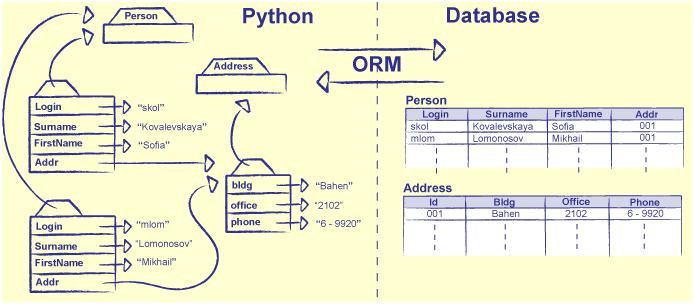!

SQLAlchemy ORM è costruito sopra all'Expression Language ed offre un livello di astrazione ancora più elevato rispetto al DBMS sottostante. La maggior parte delle applicazioni può fare uso esclusivo delle funzionalità ORM, usando l'Expression Language solo dove è veramente necessario scendere a più basso livello.

Documentazione ufficiale: https://docs.sqlalchemy.org/en/20/orm/

### Dichiarazione di un mapping

In [ ]:
import sqlalchemy as sq
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column
from sqlalchemy import Integer, String
from typing import Optional

engine = sq.create_engine('sqlite://', echo=True)


class Base(DeclarativeBase):                  # Base rappresenta lo schema (contiene MetaData) e sarà ereditato dalle classi che rappresentano una tabella
    pass

class User(Base):
    __tablename__ = 'users'                   # obbligatorio

    id: Mapped[int] = mapped_column(primary_key=True)    # almeno un attributo deve fare parte della primary key
    name: Mapped[str]=mapped_column()   #se mapped_column() con nessun parametro => è possibile ometterlo
    fullname: Mapped[str]
    nickname: Mapped[Optional[str]] #nullable

    # questo metodo è opzionale, serve solo per pretty printing
    def __repr__(self):
        return "<User(name='%s', fullname='%s', nickname='%s')>" % (self.name, self.fullname, self.nickname)

### Creare uno schema

In [ ]:
User.__table__

In [ ]:
Base.metadata.create_all(engine)

### Creare un'istanza di una classe mappata

Un'istanza di una classe mappata rappresenta una riga della tabella corrispondente.

In [ ]:
ed_user = User(name='ed', fullname='Ed Jones', nickname='thunder') #il costruttore viene generato automaticamente su tutti gli attributi
print(ed_user.name)
print(ed_user.nickname)
print(ed_user.id) #<-- non ancora assegnato

Importante: Si noti che a questo punto non è ancora stato scritto niente nel database! Questo è confermato dal fatto che l'attributo `id` è ancora impostato a `None`. Abbiamo però preparato SQLAlchemy ORM affinché sia in grado di aggiornare il database correttamente all'interno di una **sessione**.

### Sessioni: creazione ed utilizzo

Una sessione in SQLAlchemy ORM nasconde una serie di dettagli implementativi che tipicamente sono gestiti manualmente nell'Expression Language, in particolare la gestione delle connessioni e delle transazioni.

In [ ]:
from sqlalchemy.orm import Session

session = Session(engine)
# with Session(engine) as session:
session.add(ed_user)    # pending instance: verrà salvata nel database quando veramente necessario

In [ ]:
stmt = sq.select(User).where(User.name=='ed')   # qui è necessario salvare la pending instance
display(stmt)

some_users = session.scalars(stmt).fetchall()
some_users

In [ ]:
ed_user is some_users[0] #stesso oggetto

In [ ]:
print(ed_user.id)    # primary key creata in fase di scrittura al database

In [ ]:
new_user = User(name='Luca', fullname='Luca Cosmo') #il costruttore viene generato automaticamente su tutti gli attributi
session.add(new_user)
session.flush() #<-- forza la modifica del database (di solito non necessario). ATTENZIONE, la transazione non è ancora comittata!

In [ ]:
ed_user.nickname = 'eddie'

session.add_all([User(name='wendy', fullname='Wendy Williams', nickname='windy'),  #add_all inserisce una lista di entità
                 User(name='mary', fullname='Mary Contrary', nickname='mary'),
                 User(name='fred', fullname='Fred Flintstone', nickname='freddy')])

In [ ]:
#diamo un'occhiata allo stato della sincronizzazione con il DB
print("Dirty instances: " + str(session.dirty))
print("Pending instances: " + str(session.new) + "\n")
session.commit()
print("\nDirty instances: " + str(session.dirty))
print("Pending instances: " + str(session.new))

In [ ]:
ed_user.name = 'Edwardo'
fake_user = User(name='fakeuser', fullname='Invalid', nickname='12345')
session.add(fake_user)
session.scalars(sq.select(User)).fetchall()

In [ ]:
session.rollback()
print(">>> eddie's name: " + ed_user.name)
session.scalars(sq.select(User)).fetchall()

In [ ]:
session.scalars(sq.select(User)).first()

In [ ]:
session.get(User,1) #posso richiedere direttamete un oggetto concoscendone la primary key

### Relazioni

Modelliamo ora una relazione uno-a-molti fra utenti ed indirizzi email. Tale relazione consente di effettuare le seguenti operazioni:
1. Dato un indirizzo email, trovare l'utente ad esso associato
2. Dato un utente, trovare una lista dei suoi indirizzi email

Questo meccanismo viene implementato tramite `relationship` come segue. Si faccia attenzione alla creazione di due attributi in questo caso, uno per ciascuna classe. Il primo attributo implementa il punto 1, mentre il secondo attributo implementa il punto 2.

In [ ]:
from sqlalchemy.orm import relationship
from sqlalchemy import ForeignKey

class Address(Base):
     __tablename__ = 'addresses'
     
     id: Mapped[int] = mapped_column(primary_key=True)
     email_address: Mapped[str]
     user_id: Mapped[int] = mapped_column(ForeignKey(User.id), nullable=True) #nullable

     user: Mapped[User] = relationship(User, back_populates="addresses")    # qui viene sfruttata la foreign key
                                                                            #riflessione delle modifiche sulla tabella 'addresses'

     def __repr__(self):
         return "<Address(email_address='%s')>" % self.email_address

User.addresses = relationship(Address, back_populates="user", order_by=Address.id)

In [ ]:
type(User.addresses)

In [ ]:
Base.metadata.create_all(engine)

In [ ]:
jack = User(name='jack', fullname='Jack Bean', nickname='j&b')
jack.addresses

In [ ]:
jack.addresses = [Address(email_address='jack@google.com'), Address(email_address='j25@yahoo.com')]

In [ ]:
jack.addresses[0]

In [ ]:
jack.addresses[0].user

In [ ]:
jack.addresses[0].id

In [ ]:
session.add(jack)
session.commit()

In [ ]:
jack.addresses[0].id #l'id viene assegnato solo quando le query vengono eseguite

In [ ]:
jack = session.scalars(sq.select(User).filter_by(name='jack')).one()
print(jack.id)     # nota: nessuna istruzione SQL viene eseguita per la tabella addresses

In [ ]:
jack.addresses   # solo a questo punto viene eseguito SQL per la tabella addresses

In [ ]:
new_add = Address(email_address='jack2@google.com', user_id = jack.id) #è vero anche il contrario

In [ ]:
session.add(new_add)
session.commit()
jack.addresses

### Cancellazioni

In [ ]:
# session.rollback()
session.delete(jack)
print("------------ Deleted instances: " + str(session.deleted))
print(session.scalars(sq.select(sq.func.count()).select_from(User).filter(User.name == 'jack')).fetchall())
# session.commit()

In [ ]:
print('>>>> ',session.scalars(sq.select(Address)).first().user)   # politica di default: SET NULL

In [ ]:
session.rollback()
from typing import List

class Base(DeclarativeBase):                  # Base rappresenta lo schema (contiene MetaData) e sarà ereditato dalle classi che rappresentano una tabella
    pass

class User(Base):
    __tablename__ = 'users'                   # obbligatorio

    id: Mapped[int] = mapped_column(primary_key=True)    # almeno un attributo deve fare parte della primary key
    name: Mapped[str]
    fullname: Mapped[str]
    nickname: Mapped[Optional[str]] #nullable

    # configuriamo la politica di cascading
    addresses : Mapped[List[Address]] = relationship("Address", back_populates='user', cascade="all, delete, delete-orphan")

    # questo metodo è opzionale, serve solo per pretty printing
    def __repr__(self):
        return "<User(name='%s', fullname='%s', nickname='%s')>" % (self.name, self.fullname, self.nickname)

class Address(Base):
     __tablename__ = 'addresses'
     id: Mapped[int] = mapped_column(primary_key=True)
     email_address: Mapped[str]
     user_id: Mapped[int] = mapped_column(ForeignKey(User.id), nullable=True) #nullable

     user: Mapped[User] = relationship(User, back_populates="addresses")    # qui viene sfruttata la foreign key

     def __repr__(self):
         return "<Address(email_address='%s')>" % self.email_address

In [ ]:
jack = session.scalars(sq.select(User).filter(User.name == 'jack')).first()

for a in jack.addresses:
    print(a)

In [ ]:
jack.addresses

In [ ]:
del jack.addresses[1]
session.scalars(sq.select(Address).filter(Address.email_address.in_(['jack@google.com', 'j25@yahoo.com'])))

In [ ]:
session.delete(jack)
print(session.query(User).filter(User.name == 'jack').count())
print(session.query(Address).filter(Address.email_address.in_(['jack@google.com', 'j25@yahoo.com'])).count())

### Relazioni molti-a-molti

Modelliamo infine una relazione molti-a-molti fra blog post e keywords al loro interno. Ciò richiede la creazione di una **tabella di associazione**, che sporca l'eleganza della rappresentazione ORM vista fino ad ora. Tale tabella deve avere esattamente due colonne, che operano da chiavi esterne verso le due relazioni da associare.

Tramite la tabella di associazione è possibile effettuare le seguenti operazioni:
1. Dato un blog post, trovare la lista delle sue keywords
2. Data una keyword, trovare la lista dei blog post in cui occorre

Sebbene siamo costretti ad esporre tale dettaglio implementativo, l'interfaccia di accesso alle informazioni desiderate tramite l'ORM rimane comunque estremamente semplice. E' possibile estendere tale pattern a strutture con più di due colonne usando **oggetti di associazione**: per i dettagli potete consultare la documentazione ufficiale [qui](https://docs.sqlalchemy.org/en/20/orm/basic_relationships.html#relationship-patterns).

In [ ]:
from sqlalchemy import Table, Column

post_keywords = Table('post_keywords', Base.metadata,
                                       Column('post_id', ForeignKey('posts.id'), primary_key=True),
                                       Column('keyword_id', ForeignKey('keywords.id'), primary_key=True))

In [ ]:
class BlogPost(Base):
    __tablename__ = 'posts'

    id: Mapped[int] = mapped_column(primary_key=True)
    user_id: Mapped[Optional[int]] = mapped_column(ForeignKey('users.id')) #chiave esternasu utenti
    headline: Mapped[str]
    body: Mapped[Optional[str]]

    # relazione molti-a-molti
    keywords = relationship('Keyword', secondary=post_keywords, back_populates='posts')

    def __repr__(self):
        return "BlogPost(%r, %r, %r)" % (self.headline, self.body, self.author)

class Keyword(Base):
    __tablename__ = 'keywords'

    id: Mapped[int] = mapped_column(primary_key=True)
    kw: Mapped[str] = mapped_column(unique=True)

    # relazione molti-a-molti
    posts = relationship('BlogPost', secondary=post_keywords, back_populates='keywords')

Aggiungiamo poi una relazione uno-a-molti fra utenti e blog post, riutilizzando le tecniche già viste. Si noti che avevamo già introdotto una chiave esterna su `BlogPost` per questo compito.

In [ ]:
BlogPost.author = relationship(User, back_populates="posts")
User.posts = relationship(BlogPost, back_populates="author")

In [ ]:
Base.metadata.create_all(engine)

In [ ]:
# aggiungiamo un blog post creato da wendy
wendy = session.scalars(sq.select(User).filter_by(name='wendy')).one()
posts = relationship('BlogPost', secondary=post_keywords, back_populates='keywords')
post = BlogPost(headline="Wendy's Blog Post", body="This is a test", author=wendy)
session.add(post)

In [ ]:
session.commit()

In [ ]:
post.keywords = [Keyword(kw='wendy'), Keyword(kw='firstpost')]

In [ ]:
session.scalars(sq.select(BlogPost).filter(BlogPost.keywords.any(kw='firstpost'))).all()

In [ ]:
session.scalars(sq.select(BlogPost).filter(BlogPost.author == wendy)).all()

In [ ]:
wendy.posts

## Reflection
Come visto per SQLAlchemy Core, è possibile usare la reflection anche nella modalità ORM per popolare le classi a partire da tabelle esistenti. Questo è molto conveniente perchè non vi costringe a definire esplicitamente la struttura delle classi quando vi collegate ad un database già esistente.

In [ ]:
users = Table("users", Base.metadata, autoload_with=engine)
users

In [ ]:
class User2(Base):
  __table__ = users

  def __repr__(self):
    return "<User(name='%s', fullname='%s', nickname='%s')>" % (self.name, self.fullname, self.nickname)

session.scalars(sq.select(User2)).all()

In [ ]:
Base.metadata.reflect(engine) #carica tutte le tabelle dal database

class User2(Base):
    __table__ = Base.metadata.tables['users'] #tabella precaricata su metadata

    def __repr__(self):
        return "<User(name='%s', fullname='%s', nickname='%s')>" % (self.name, self.fullname, self.nickname)

session.scalars(sq.select(User2)).all()

In [ ]:
class User2(Base):
    __table__ = Base.metadata.tables['users'] #tabella precaricata su metadata
    __mapper_args__ = {
        "include_properties": [__table__.c.id, __table__.c.nickname, __table__.c.address]  #subset di aattributi
    }


u = session.scalars(sq.select(User2)).first()
u.__dict__


### Autoload: crea automaticamente le classi

In [ ]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

AutoBase = automap_base()
AutoBase.prepare(engine) #carica tutte le tabelle dal database

User2 = AutoBase.classes.users

In [ ]:
u = session.get(User2,3)
u.posts_collection

In [ ]:
class Post2(Base):
  __table__ = Base.metadata.tables['posts']

p = session.scalars(sq.select(Post2)).first()
dir(p)

## Esercizio

Creare tramite SQLAlchemy ORM le seguenti tabelle:
* Product(maker, model*, type)
* PC(<u>model*</u>, speed, ram, hd, price)
* Laptop(<u>model*</u>, speed, ram, hd, screen, price)
* Printer(<u>model*</u>, color, type, price)

Definite opportune chiavi primarie ed esterne, scegliendo i tipi di dato appropriati per i vari attributi. Una volta fatto ciò, popolate le tabelle con alcuni dati artificiali ed effettuate tramite l'ORM di SQLAlchemy le seguenti query:
1. Trovare il modello, la velocità e la dimensione dell'hard disk di tutti i PC che costano meno di $1000.
2. Trovare tutti i produttori di stampanti.
3. Trovare il produttore e la velocità dei laptop con un hard disk da almeno 300 GB.
4. Trovare il modello ed il prezzo di tutti i PC ed i laptop realizzati dalla Lenovo.
5. Trovare le dimensioni degli hard disk che occorrono in almeno due PC.
6. Trovare tutte le aziende che producono laptop, ma non PC.
7. Trovare i produttori di PC con una velocità minima di 2.0 GHz.
8. Trovare tutte le aziende che producono sia PC che laptop.

Procedete immaginando la query SQL e traducendola nell'ORM di SQLAlchemy. Consultate la documentazione dove necessario.